<a href="https://colab.research.google.com/github/AUT-Student/NN-HW3/blob/main/NN_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from copy import deepcopy

# Dataset

In [2]:
!gdown https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O "/content/Dataset.zip"

Downloading...
From: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
To: /content/Dataset.zip
100% 61.0M/61.0M [00:00<00:00, 77.9MB/s]


In [3]:
!unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HA

In [4]:
!gdown https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names -O "/content/Dataset.names"

Downloading...
From: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names
To: /content/Dataset.names
100% 6.30k/6.30k [00:00<00:00, 6.23MB/s]


In [5]:
!cat "/content/Dataset.names"

Human Activity Recognition Using Smartphones Dataset
Version 1.0
Jorge L. Reyes-Ortiz(1,2), Davide Anguita(1), Alessandro Ghio(1), Luca Oneto(1) and Xavier Parra(2)
1 - Smartlab - Non-Linear Complex Systems Laboratory
DITEN - Universit�  degli Studi di Genova, Genoa (I-16145), Italy. 
2 - CETpD - Technical Research Centre for Dependency Care and Autonomous Living
Universitat Polit�cnica de Catalunya (BarcelonaTech). Vilanova i la Geltr� (08800), Spain
activityrecognition '@' smartlab.ws 

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained data

In [6]:
!cat "/content/UCI HAR Dataset/activity_labels.txt"

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [7]:
X_train = pd.read_csv("/content/UCI HAR Dataset/train/X_train.txt", delimiter=r"\s+", header=None)
X_test = pd.read_csv("/content/UCI HAR Dataset/test/X_test.txt", delimiter=r"\s+", header=None)
y_train = pd.read_csv("/content/UCI HAR Dataset/train/y_train.txt", delimiter=r"\s+", header=None)
y_test = pd.read_csv("/content/UCI HAR Dataset/test/y_test.txt", delimiter=r"\s+", header=None)

In [8]:
X_train["Class"] = y_train
X_test["Class"] = y_test

In [9]:
X_valid, X_train = np.split(X_train.sample(frac=1, random_state=0), [int(.125*len(X_train))])

In [10]:
y_train = X_train["Class"]
X_train = X_train.drop(columns=["Class"])

y_valid = X_valid["Class"]
X_valid = X_valid.drop(columns=["Class"])

In [11]:
y_train = y_train.apply(lambda x:x-1)
y_test = y_test.apply(lambda x:x-1)
y_valid = y_valid.apply(lambda x:x-1)

# MLP Classifer

## Model

In [ ]:
class MLPModel(keras.Model):
  def __init__(self, number_hidden_layers, number_hidden_units):
    super().__init__()

    if number_hidden_layers<0:
      raise Exception("The number of hidden layers must be a non-negetive number")

    if number_hidden_layers != len(number_hidden_units):
      raise Exception("The number of hidden layers must equal to the length of the number of hidden units list")

    self.model = keras.models.Sequential()

    for i in range(number_hidden_layers):
      self.model.add(keras.layers.Dense(units=number_hidden_units[i], activation="relu", name=f"Dense_Layer_{i+1}"))

    self.model.add(keras.layers.Dense(6, activation="softmax", name="Output_Layer"))

  def call(self, inputs):
    return self.model(inputs)

In [ ]:
def train_and_evaluate(number_hidden_layers, number_hidden_units, learning_rate):
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5)

  model = MLPModel(number_hidden_layers=number_hidden_layers, number_hidden_units=number_hidden_units)

  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0, callbacks=[es_callback])

  train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
  validation_accuracy = model.evaluate(X_valid, y_valid, verbose=0)[1]

  print(f"Train = {round(train_accuracy*100, 2)}, Validation = {round(validation_accuracy*100, 2)}")

## Learning Rate Fine-tuning

In [ ]:
for learning_rate in [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.1]:
  print(f"Learning Rate = {learning_rate}")
  train_and_evaluate(number_hidden_layers=3, number_hidden_units=[128, 64, 32], learning_rate=0.001)
  print("")

Learning Rate = 0.0001
Train = 98.83, Validation = 97.71

Learning Rate = 0.0005
Train = 98.85, Validation = 97.82

Learning Rate = 0.001
Train = 97.95, Validation = 96.52

Learning Rate = 0.003
Train = 98.8, Validation = 98.04

Learning Rate = 0.005
Train = 98.4, Validation = 97.17

Learning Rate = 0.01
Train = 98.77, Validation = 97.93

Learning Rate = 0.1
Train = 98.57, Validation = 97.93



## Number Layer and Number Neuron Fine-tuning

In [ ]:
train_and_evaluate(number_hidden_layers=0, number_hidden_units=[], learning_rate=0.003)
print("")

Train = 98.82, Validation = 97.93



In [ ]:
for number_hidden_units in [[32], [64], [128]]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=1, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [32]
Train = 98.96, Validation = 97.93

number_hidden_units = [64]
Train = 98.87, Validation = 97.82

number_hidden_units = [128]
Train = 98.87, Validation = 98.04



In [ ]:
for number_hidden_units in [
                            [32, 32], [64, 32], [128, 128]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=2, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [32, 32]
Train = 98.87, Validation = 98.26

number_hidden_units = [64, 32]
Train = 98.4, Validation = 97.06

number_hidden_units = [128, 128]
Train = 97.28, Validation = 96.63



In [ ]:
for number_hidden_units in [
                            [64, 32, 32], [64, 64, 64], [128, 64, 32]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=3, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [64, 32, 32]
Train = 98.49, Validation = 97.71

number_hidden_units = [64, 64, 64]
Train = 98.15, Validation = 97.39

number_hidden_units = [128, 64, 32]
Train = 98.26, Validation = 97.28



In [ ]:
for number_hidden_units in [
                            [128, 128, 64, 64], [128, 64, 32, 16], [128, 64, 32, 64]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=4, number_hidden_units=number_hidden_units, learning_rate=0.05)
  print("")

number_hidden_units = [128, 128, 64, 64]
Train = 18.76, Validation = 18.17

number_hidden_units = [128, 64, 32, 16]
Train = 52.45, Validation = 50.82

number_hidden_units = [128, 64, 32, 64]
Train = 18.76, Validation = 18.17



# SOM

In [20]:
import colorsys

class SOM():
  def __init__(self, number_epochs, map_size, number_features,
               initial_learning_rate, initial_radius, radius_decay, X_train):
    
    self.number_epochs = number_epochs
    self.map_size = map_size
    self.number_features = number_features
    self.learning_rate = initial_learning_rate
    self.radius_decay = radius_decay
    self.radius = initial_radius
    self.initial_learning_rate = initial_learning_rate
    
    self._initiate_weight(X_train)

    self.visualize(X_train, y_train.to_numpy())

  def _initiate_weight(self, X_train):

    self.weight = []
    for i in range(self.map_size[0]):
      row_list = []
      for j in range(self.map_size[1]):
        row_list.append(X_train[np.random.choice(X_train.shape[0])])
      self.weight.append(row_list)
    self.weight = np.array(self.weight)

  def train(self, X_train):
    self.weight_changes_list = []
    for epoch in range(self.number_epochs):
      print(f"epoch = {epoch}")
      prev_weight = deepcopy(self.weight)
      for i, row in enumerate(X_train):
        winner = self.find_winner(row)
        NS = self.calculate_NS(row, winner)
        self.update_weights(NS, row)

      self.weight_changes_list.append(np.linalg.norm(prev_weight - self.weight))

      self.learning_rate -= (self.initial_learning_rate/self.number_epochs)
      self.radius *= self.radius_decay

  def find_winner(self, row):
    winner = np.argmin(np.sum((np.tile(row, (self.map_size[0], self.map_size[1], 1)) - self.weight)**2, axis=2))
    winner = (winner//self.map_size[1], winner%self.map_size[1])
    return winner

  def calculate_NS(self, row, winner):
    NS = np.zeros(self.map_size)

    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
          neuron_distance = self.distance(np.array((i, j)), np.array(winner))

          if neuron_distance <= self.radius:
            NS[i][j] = 1 - neuron_distance / self.radius
    
    return NS

  def update_weights(self, NS, row):
    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):

        delta = row - self.weight[i][j]
        self.weight[i][j] += NS[i][j] * self.learning_rate * delta

  def visualize(self, X_train, y_train):
    number_labels = len(set(y_train))
    self.scores = np.zeros((self.map_size[0], self.map_size[1], number_labels))

    for i in range(len(X_train)):
      row = X_train[i]
      label = y_train[i]
      winner = self.find_winner(row)
      self.scores[winner[0]][winner[1]][label] += 1

    best_label = np.zeros((self.map_size[0], self.map_size[1]), dtype=int)

    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
        if np.all(self.scores[i][j] == 0):
          best_label[i][j] == number_labels + 1
        else:
          best_label[i][j] = np.argmax(self.scores[i][j])

    label_colors = self._get_colors(number_labels)
    label_colors.append((0, 0, 0))

    map_color = []
    for i in range(self.map_size[0]):
      map_row_color = []
      for j in range(self.map_size[1]):
        map_row_color.append(label_colors[best_label[i][j]])
      map_color.append(map_row_color)
    
    plt.imshow(map_color)
    plt.show()

  def plot_weight_changes(self):
    plt.xlabel("Epoch")
    plt.ylabel("Weight Change")
    plt.title("Weight Changing Over Epochs")
    plt.plot(som.weight_changes_list, color="purple")
    plt.show()

  @staticmethod
  def distance(array1, array2):
    return np.linalg.norm(array1 - array2)

  @staticmethod
  def _get_colors(num_colors):
      colors=[]
      for i in np.arange(0., 360., 360. / num_colors):
          hue = i/360.
          lightness = (50 + np.random.rand() * 10)/100.
          saturation = (90 + np.random.rand() * 10)/100.
          colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
      return colors

In [21]:
som = SOM(number_epochs=50, map_size=(5,5), number_features=len(X_train.columns),
               initial_learning_rate=0.0001, initial_radius=5,
               radius_decay=0.95, X_train=X_train.to_numpy())

(6, 2)
******
[[ 26.76230286  31.16292988  76.14005799  67.06880664  75.31673631]
 [ 29.87471403  59.99336999  47.52182304  67.98103443  34.33395624]
 [ 34.58967315 134.44153462  35.01959254  70.63557362 123.74257799]
 [165.66739192 123.84934672  35.89316481  30.1558527   48.63499129]
 [ 77.97219149  87.52758251  61.74143871 148.8227716   48.61985289]
 [ 69.12498476  63.78206831 152.02775655  30.03338583 183.62385323]
 [164.16807301  60.05109775  25.13359015  44.37733932  32.93769234]
 [106.0613655  130.44792163  78.06210063 158.43807144  36.00111311]
 [ 82.05089171  44.3881461   47.39758697  27.6930905   27.68208603]]
32
(6, 2)


KeyboardInterrupt: ignored

In [ ]:
np.squeeze(np.array([[1,2]]))

array([1, 2])

In [ ]:
som.train(X_train.to_numpy())

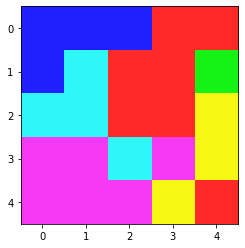

In [ ]:
som.visualize(X_train.to_numpy(), y_train.to_numpy())

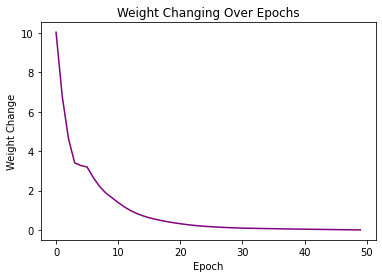

In [ ]:
som.plot_weight_changes()

In [ ]:
row = X_train.to_numpy()[0]

In [ ]:
np.argmax(np.array([[1,2],[0,5]]), axis=1)

array([1, 1])

In [ ]:
np.tile(row, (3,3, 1)).shape

(3, 3, 561)

In [ ]:
len(row)

561

In [ ]:
np.sum(np.array([[1,2],[3,4]]), axis=2)

AxisError: ignored

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
1196,0.274415,-0.015365,-0.089577,-0.977204,-0.844724,-0.901338,-0.980053,-0.835494,-0.896651,-0.919487,...,0.414775,-0.152583,-0.577994,0.171742,-0.057348,0.622494,-0.421532,-0.844238,0.129549,0.126252
6746,0.378128,-0.021631,-0.134946,-0.218459,-0.133410,-0.241415,-0.221506,-0.150054,-0.246992,-0.073054,...,0.137933,-0.130561,-0.576274,-0.668277,0.214077,0.275911,0.195506,-0.835773,0.174898,-0.069622
6219,0.241018,-0.023779,-0.149122,-0.319574,0.031652,-0.200073,-0.359776,0.021921,-0.158302,-0.183947,...,0.292842,-0.280510,-0.550137,0.048369,-0.503804,-0.853310,-0.729661,-0.546802,0.261428,0.291004
4982,0.269496,-0.019287,-0.106867,-0.964469,-0.966990,-0.982618,-0.964586,-0.963221,-0.983236,-0.912592,...,0.401100,0.009948,-0.319006,0.042092,0.033528,0.162483,0.373684,0.553159,-0.212752,-0.804338
812,0.202550,-0.017049,-0.101957,0.283359,0.023602,-0.290198,0.227207,-0.080051,-0.301953,0.529405,...,-0.226830,-0.284462,-0.714534,0.922006,0.998425,-0.849653,-0.328409,-0.993952,0.098064,0.011644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.292627,-0.017491,-0.082785,-0.984160,-0.943641,-0.844642,-0.985363,-0.947178,-0.842207,-0.916906,...,-0.079717,-0.254130,-0.628941,-0.162713,0.515776,0.506718,-0.579462,-0.884235,0.041103,0.080667
3264,0.276011,-0.017833,-0.108782,-0.999012,-0.993991,-0.994970,-0.998858,-0.993352,-0.995265,-0.945600,...,0.470136,-0.698030,-0.903358,0.263036,0.202038,0.389661,-0.689069,-0.668749,0.218478,0.219102
1653,0.383254,-0.060821,-0.230736,-0.880962,-0.626535,-0.833755,-0.888587,-0.614349,-0.819403,-0.723865,...,-0.498263,-0.149884,-0.577270,-0.041335,0.173456,0.629785,-0.385363,-0.609972,-0.111308,-0.158247
2607,0.273439,-0.016149,-0.108189,-0.995842,-0.989843,-0.991254,-0.996346,-0.991258,-0.991739,-0.939091,...,0.535472,-0.673452,-0.917552,-0.234780,0.611080,0.283389,-0.286049,0.449830,-0.699381,-0.280821
